In [148]:
import pygplates
import sys
import numpy as np
sys.path.append('../../GPlatesClassStruggle')
sys.path.append('../../atom_utils')
sys.path.append('../../passive_margins/')
from raster_reconstruction_classes import *
import matplotlib.pyplot as plt
from reconstruct_atom_rasters import *
import points_spatial_tree
import points_in_polygons
import paleogeography as pg
import tectonic_subsidence as ts 

%matplotlib inline
%load_ext autoreload
%autoreload 2


agegrid = GplatesRaster('../data/agegrid_6m.grd')

topography = GplatesRaster('../data/ETOPO1_0.1.grd')

anomalous_ocean = GplatesRaster('../data/Wessel_lip_seamount_mask.nc')

sediment_thickness = GplatesRaster('../data/sedthick_world_v3_5min_epsg4326_cf.nc')


#rotation_filename = '/Users/Simon/GIT/gplates-web-service/django/GWS/DATA/MODELS/SETON2012/Seton_etal_ESR2012_2012.1.rot'
rotation_filename = '/Users/Simon/GIT/agegrid-dev/input_files/Rotations/Matthews_etal_GPC_2016_410-0Ma_GK07.rot'

# Note: must be static polygons that have the conjugate plateid assigned
static_polygon_filename = '/Users/Simon/GIT/passive_margins/input_data/StaticPolygons/Global_EarthByte_GPlates_PresentDay_StaticPlatePolygons_2015_v1.shp'




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [149]:
rotation_model = pygplates.RotationModel(rotation_filename)
static_polygon_features = pygplates.FeatureCollection(static_polygon_filename)

#static_polygon_features = []
#for static_polygon_feature in static_polygon_features_tmp:
#    if static_polygon_feature.get_geometry() is not None:
#        static_polygon_features.append(static_polygon_feature)


In [150]:
# generate a list of lat,lon points with an equal area distribution on the sphere
equal_area_points = PointDistributionOnSphere(distribution_type='healpix',N=128)

points = [point.to_lat_lon_point() for point in equal_area_points.multipoint.get_points()]


In [151]:
# For each point, get the plate id and conjugate plate id from its containing static polygon
# Finally, sample the age grid

spatial_tree_of_uniform_recon_points = points_spatial_tree.PointsSpatialTree(points)

recon_static_polygons = []
recon_static_polygon_plate_ids = []
for static_polygon_feature in static_polygon_features:
    recon_plate_id = static_polygon_feature.get_reconstruction_plate_id()
    recon_conjugate_plate_id = static_polygon_feature.get_conjugate_plate_id()
    recon_polygon = static_polygon_feature.get_geometry()

    recon_static_polygon_plate_ids.append((recon_plate_id,recon_conjugate_plate_id))
    recon_static_polygons.append(recon_polygon)
        
point_plate_pairs = points_in_polygons.find_polygons_using_points_spatial_tree(
    points, spatial_tree_of_uniform_recon_points, recon_static_polygons, recon_static_polygon_plate_ids)

point_ages = point_age = agegrid.sample_using_gmt(equal_area_points.longitude,equal_area_points.latitude)



In [152]:
def return_conjugate_points(target_plate_pair):

    points_and_conjugate_points = []
    for point, point_age, plate_ids in zip(points, point_ages, point_plate_pairs):

        if plate_ids is None:
            continue
        elif plate_ids[0] not in target_plate_pair:
            continue
        elif plate_ids[1] not in target_plate_pair:
            continue
        else:
            
            if not np.isnan(point_age):

                finite_rotation = rotation_model.get_rotation(float(point_age), int(plate_ids[0]), 0, int(plate_ids[1]))

                reconstructed_point = finite_rotation * pygplates.PointOnSphere(point)

                points_and_conjugate_points.append([point.to_lat_lon()[1],
                                                    point.to_lat_lon()[0],
                                                    reconstructed_point.to_lat_lon()[1],
                                                    reconstructed_point.to_lat_lon()[0],
                                                    plate_ids[0],
                                                    point_age])
            
    return points_and_conjugate_points


###################
rho_mantle = 3300
rho_water = 1030
phi = 0.56
c = 4.5
#q = 2500

def get_unloaded_bsmt_depth(lons,lats):
    
    point_depth = topography.sample_using_gmt(lons, lats)    
    
    point_sed_thick = sediment_thickness.sample_using_gmt(lons, lats)  
    
    rhoSbar = ts.AverageSedimentDensity(point_sed_thick, phi=phi, c=c)
    
    q = ts.AverageDensityAboveBasement(rhoSbar,point_sed_thick,point_depth)
    
    delta_z = (rho_mantle*point_sed_thick - q) / (rho_mantle - rho_water)
    
    unloaded_bsmt_depth = point_depth - delta_z
    
    return unloaded_bsmt_depth


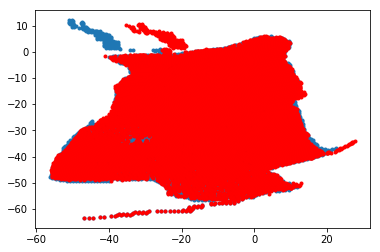

In [153]:
points_and_conjugate_points = return_conjugate_points([701,201])

plt.plot(zip(*points_and_conjugate_points)[0],zip(*points_and_conjugate_points)[1],'.')
plt.plot(zip(*points_and_conjugate_points)[2],zip(*points_and_conjugate_points)[3],'r.')
plt.show()


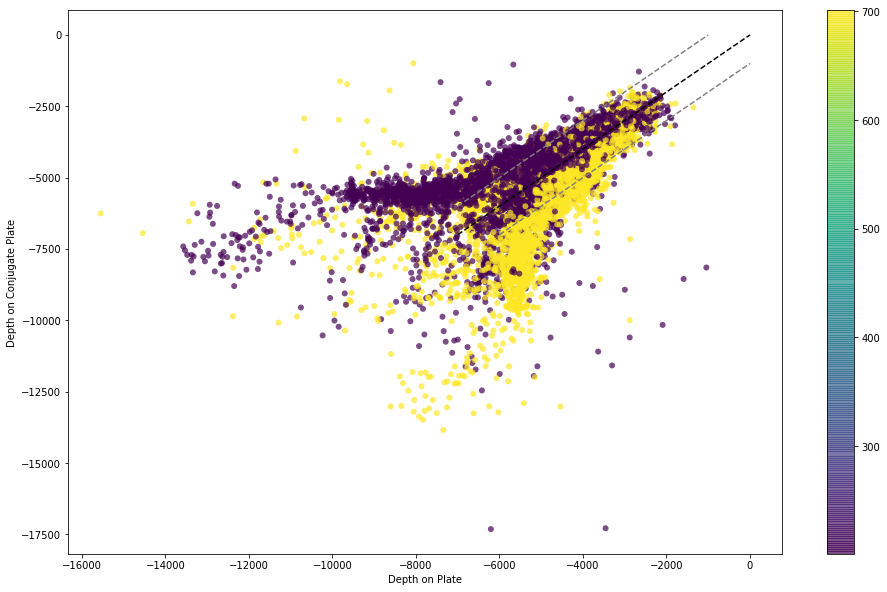

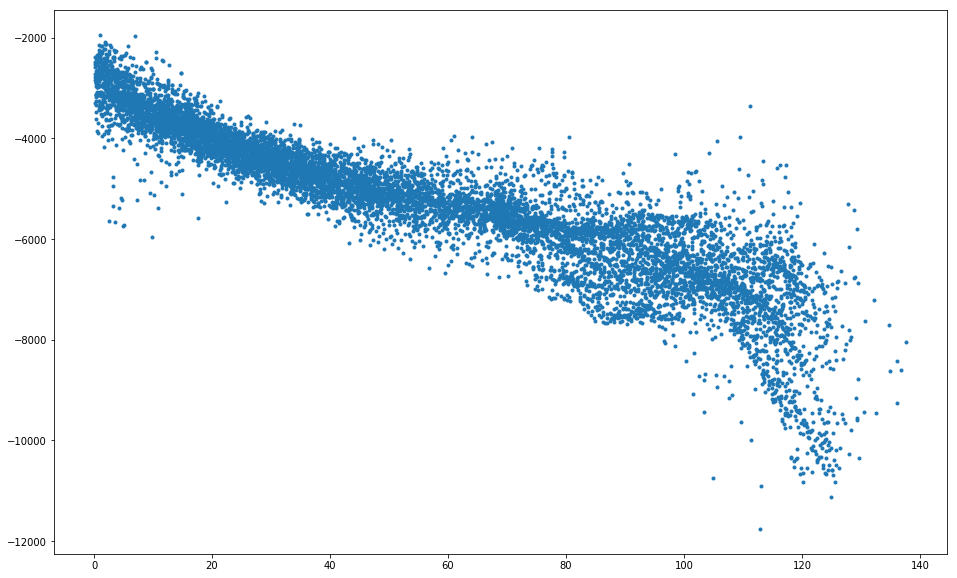

In [154]:
   
point_depth = get_unloaded_bsmt_depth(zip(*points_and_conjugate_points)[0],zip(*points_and_conjugate_points)[1])    
conj_point_depth = get_unloaded_bsmt_depth(zip(*points_and_conjugate_points)[2],zip(*points_and_conjugate_points)[3])

point_depth_mask = anomalous_ocean.sample_using_gmt(zip(*points_and_conjugate_points)[0],zip(*points_and_conjugate_points)[1])    
conj_point_depth_mask = anomalous_ocean.sample_using_gmt(zip(*points_and_conjugate_points)[2],zip(*points_and_conjugate_points)[3])
mask = np.any(np.vstack((point_depth_mask,conj_point_depth_mask)),axis=0)


#print point_depth[mask]
#print zip(*points_and_conjugate_points)[4][mask]

plt.figure(figsize=(16,10))
#plt.plot(point_depth,conj_point_depth,'r.',alpha=0.7)
#plt.plot(point_depth_701,conj_point_depth_701,'b.',alpha=0.7)
plt.scatter(point_depth[~mask],conj_point_depth[~mask],c=np.array(zip(*points_and_conjugate_points)[4])[~mask],edgecolors='',alpha=0.7)
plt.plot([-7000,0],[-7000,0],'k--')
plt.plot([-7000,-1000],[-6000,0],'--',color='gray')
plt.plot([-6000,0],[-7000,-1000],'--',color='gray')
plt.xlabel('Depth on Plate')
plt.ylabel('Depth on Conjugate Plate')
#plt.legend(['South America','Africa'])
plt.colorbar()

plt.figure(figsize=(16,10))
plt.plot(np.array(zip(*points_and_conjugate_points)[5])[~mask],np.mean(np.vstack((point_depth,conj_point_depth)),axis=0)[~mask],'.')
plt.show()


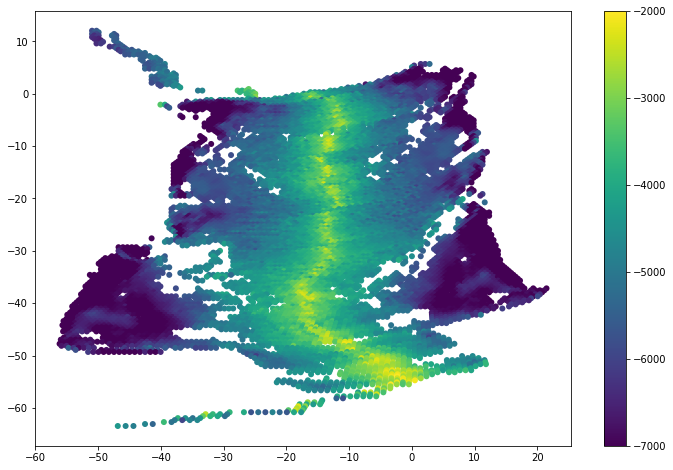

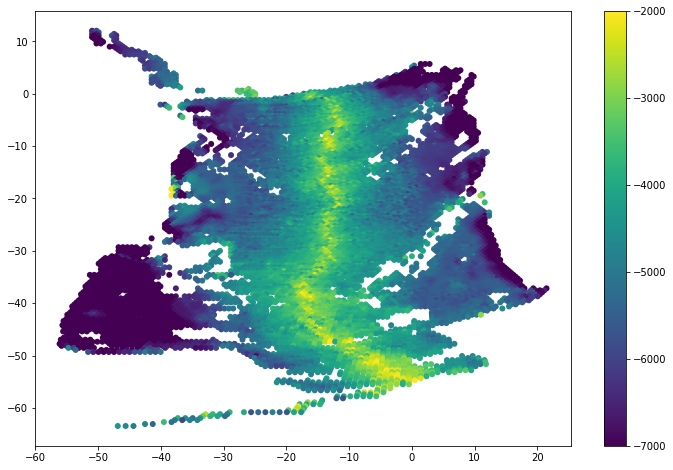

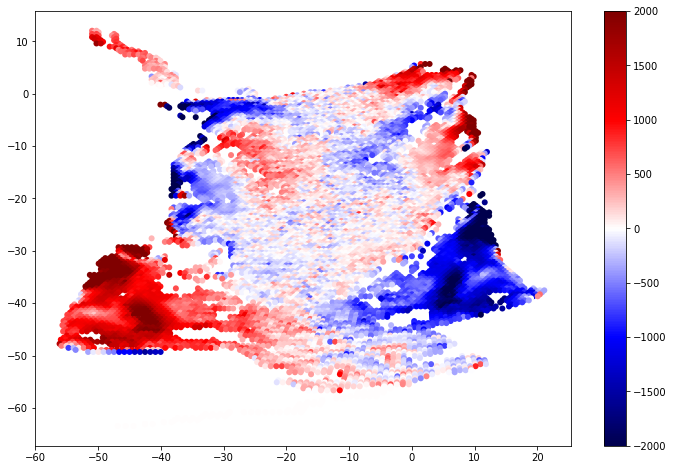

In [155]:
plt.figure(figsize=(12,8))
plt.scatter(np.array(zip(*points_and_conjugate_points)[0])[~mask],
            np.array(zip(*points_and_conjugate_points)[1])[~mask],
            c=np.mean(np.vstack((point_depth,conj_point_depth)),axis=0)[~mask],
            edgecolors='',vmin=-7000,vmax=-2000)
plt.colorbar()

plt.figure(figsize=(12,8))
plt.scatter(np.array(zip(*points_and_conjugate_points)[0])[~mask],
            np.array(zip(*points_and_conjugate_points)[1])[~mask],
            c=point_depth[~mask],
            edgecolors='',vmin=-7000,vmax=-2000)
plt.colorbar()

# Asymmetry in present-day depth - the difference between each point and its conjugate
plt.figure(figsize=(12,8))
plt.scatter(np.array(zip(*points_and_conjugate_points)[0])[~mask],
            np.array(zip(*points_and_conjugate_points)[1])[~mask],
            c=np.mean(np.vstack((point_depth,conj_point_depth)),axis=0)[~mask] - point_depth[~mask],
            edgecolors='',vmin=-2000,vmax=2000,
            cmap=plt.cm.seismic)
plt.colorbar()
                  

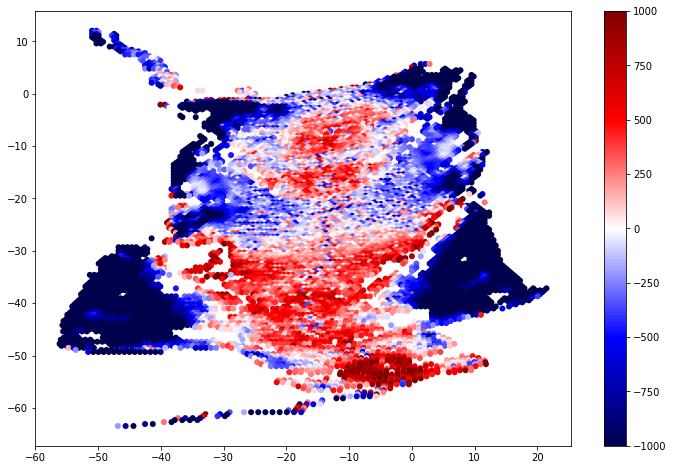

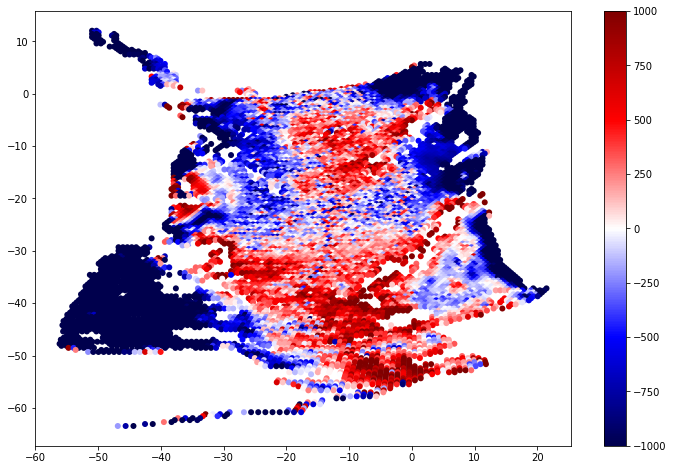

In [156]:
#print zip(*points_and_conjugate_points)[5]#print  
a2d = pg.age2depth(np.array(zip(*points_and_conjugate_points)[5]))

asymmetric_residual_basement_depth = point_depth - a2d
symmetric_residual_basement_depth = np.mean(np.vstack((point_depth,conj_point_depth)),axis=0) - a2d

plt.figure(figsize=(12,8))
plt.scatter(np.array(zip(*points_and_conjugate_points)[0])[~mask],
            np.array(zip(*points_and_conjugate_points)[1])[~mask],
            c=symmetric_residual_basement_depth[~mask],
            edgecolors='',vmin=-1000,vmax=1000,
            cmap=plt.cm.seismic)
plt.colorbar()

plt.figure(figsize=(12,8))
plt.scatter(np.array(zip(*points_and_conjugate_points)[0])[~mask],
            np.array(zip(*points_and_conjugate_points)[1])[~mask],
            c=asymmetric_residual_basement_depth[~mask],
            edgecolors='',vmin=-1000,vmax=1000,
            cmap=plt.cm.seismic)
plt.colorbar()


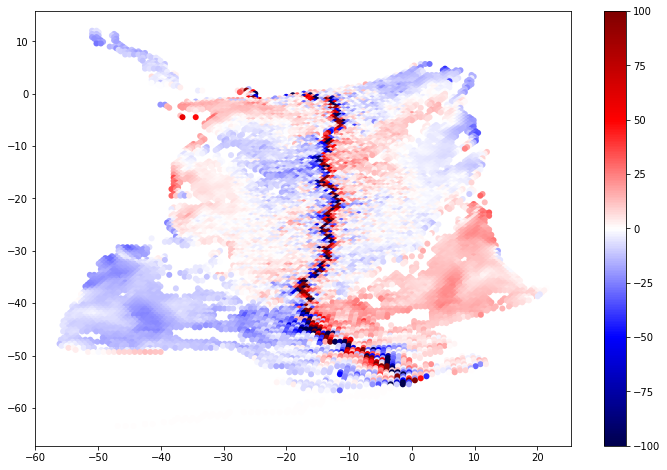

In [157]:
# the term anomalous subsidence is used to describe the different between the expected depth based
# on age depth relationship and the the depth we need will impose to ensure the ocean basin
# always looks symmetric
# We 'know' the anomalous subsidence at two times:
# 1. present-day
# 2. The birth time of the point and its conjugate
# Values in between are derived by linear interpolation

# Example:
# suppose point A lies on 50 Ma crust, and has a residual topography at present-day of +500m
# its conjugate (point B) has a residual topography of +100m
# --> at 50 Ma, we assume the MOR depth was 300 m above 'normal' (which is 2600m?)
# --> assume that the 'anomalous' depth for point A changes linearly from 500m to 300m between 0Ma and 50Ma
# --> 'anomalous' depth for point A changes linearly from 100m to 300m between 0Ma and 50Ma

# --> Rate of anomalous subsidence - positive values mean the residual depth has been increasing through time (greater now than in the past)
anomalous_subsidence_rate = (asymmetric_residual_basement_depth - symmetric_residual_basement_depth) / np.array(zip(*points_and_conjugate_points)[5])

plt.figure(figsize=(12,8))
plt.scatter(np.array(zip(*points_and_conjugate_points)[0])[~mask],
            np.array(zip(*points_and_conjugate_points)[1])[~mask],
            c=anomalous_subsidence_rate[~mask],
            edgecolors='',vmin=-100,vmax=100,
            cmap=plt.cm.seismic)
plt.colorbar()


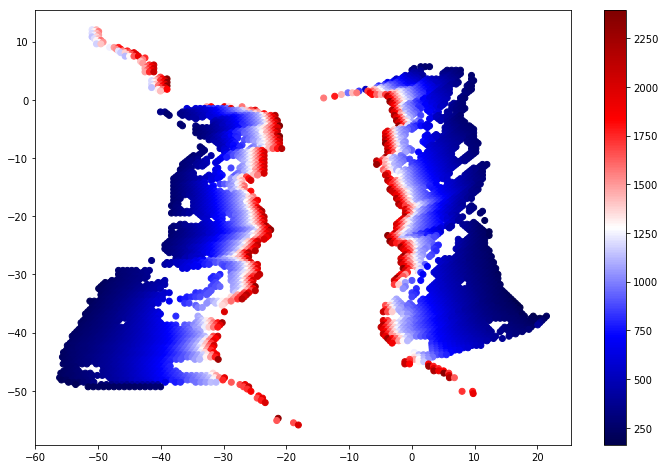

In [158]:
# Choose a time for which to derive backtracked paleotopography
# (Not yet in reconstructed coordinates)
# To figure out the 'expected' subsidence from age depth relationship,
# look at different between the expected depth at present versus reconstruction time
# for each point (since subsidence varies by seafloor age at each point)

recon_time = 50.

# expected depth at present
a2d_present = pg.age2depth(np.array(zip(*points_and_conjugate_points)[5]))

# expected depth at reconstruction time
a2d_recon = pg.age2depth(np.array(zip(*points_and_conjugate_points)[5]) - recon_time)

# expected subsidence between present and reconstruction time
expected_subsidence = a2d_recon - a2d_present

plt.figure(figsize=(12,8))
plt.scatter(np.array(zip(*points_and_conjugate_points)[0])[~mask],
            np.array(zip(*points_and_conjugate_points)[1])[~mask],
            c=expected_subsidence[~mask],
            cmap=plt.cm.seismic)
plt.colorbar()


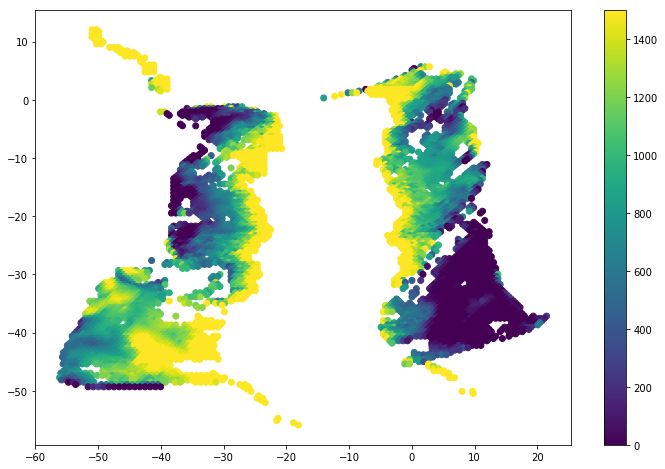

In [159]:
# Derive the total subsidence for each point at the given reconstruction time,
# accounting for both expected and anomalous component

anomalous_subsidence_at_recon_time = anomalous_subsidence_rate * recon_time

total_subsidence = expected_subsidence - anomalous_subsidence_at_recon_time

plt.figure(figsize=(12,8))
plt.scatter(np.array(zip(*points_and_conjugate_points)[0])[~mask],
            np.array(zip(*points_and_conjugate_points)[1])[~mask],
            c=total_subsidence[~mask],
            vmin=0, vmax=1500)
plt.colorbar()


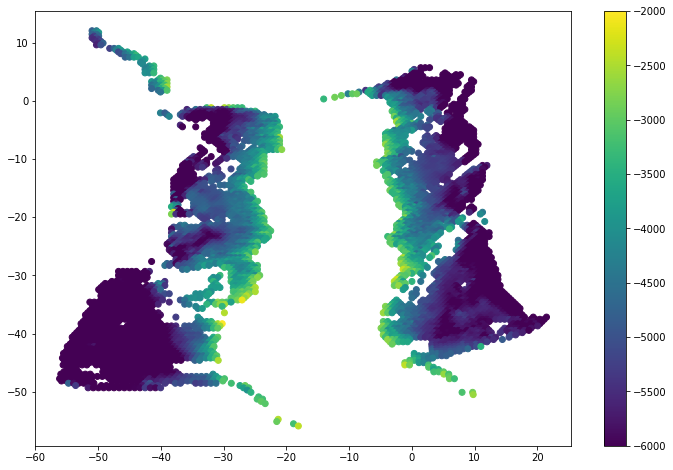

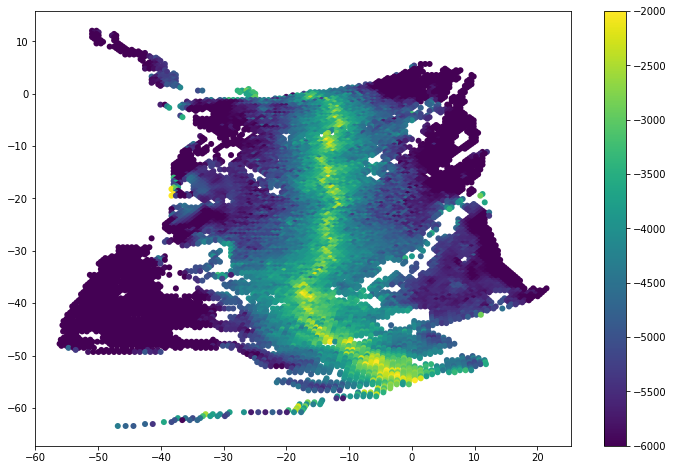

In [160]:
# the backtracked depth is the depth at present day (which is negative), 
# plus the positive value that expresses the combination of expected subsidence 
# (from the age-depth relationship) plus the anomalous subsidence determined from present-day residual topography

backtracked_depth = point_depth + total_subsidence

plt.figure(figsize=(12,8))
plt.scatter(np.array(zip(*points_and_conjugate_points)[0])[~mask],
            np.array(zip(*points_and_conjugate_points)[1])[~mask],
            c=backtracked_depth[~mask],
            vmin=-6000,vmax=-2000)
plt.colorbar()

plt.figure(figsize=(12,8))
plt.scatter(np.array(zip(*points_and_conjugate_points)[0])[~mask],
            np.array(zip(*points_and_conjugate_points)[1])[~mask],
            c=point_depth[~mask],
            edgecolors='',vmin=-6000,vmax=-2000)
plt.colorbar()
